<a href="https://colab.research.google.com/github/abhinavdayal/EVA4/blob/master/S11/S11_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1 - Creating Curves

We need to plot triangular and one cycle policy. We are using following values:
* epochs = 24
* batchsize = 128
* maxatepoch = 5
* lrmin = 0.1
* lrmax = 0.8
* trainlen = 50000

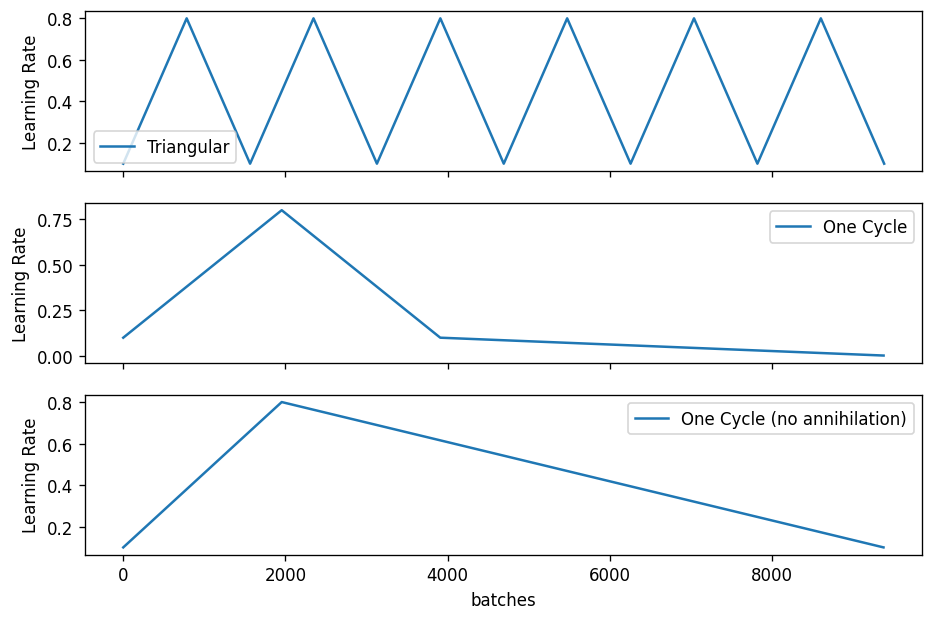

In [1]:
import matplotlib.pyplot as plt
import numpy as np

epochs = 24
batchsize = 128
maxatepoch = 5
lrmin = 0.1
lrmax = 0.8
trainlen = 50000

def getiters(datasize, batchsize):
  l = datasize//batchsize
  if datasize%batchsize:
    l += 1
  return l


def plotcycles(epochs, batchsize, maxatepoch, lrmin, lrmax, trainlen):
  plt.rcParams.update({'figure.figsize':(9,6), 'figure.dpi':120})
  fig, axes = plt.subplots(3, 1, sharex="col")

  stepsize = 2*getiters(trainlen, batchsize)
  x = np.linspace(lrmin, lrmax, stepsize)
  x = np.concatenate((x, x[::-1]), axis=None)
  xtriangular = x
  for i in range(1, epochs//4): # since a step is 2 epochs, we have consumed 4 epochs in one triangle
    xtriangular = np.concatenate((xtriangular, x), axis=None)
  axes[0].plot(xtriangular, label='Triangular')
  axes[0].set_ylabel('Learning Rate')
  axes[0].legend(('Triangular',))

  niters = getiters(maxatepoch*trainlen, batchsize)
  annealingepochs = epochs - 2*maxatepoch
  annealingiters = getiters(annealingepochs*trainlen, batchsize)

  x = np.linspace(lrmin, lrmax, niters)
  onecycle =  np.concatenate((x, x[::-1], np.linspace(lrmin, lrmin/50, annealingiters)), axis=None)
  axes[1].plot(onecycle, label='One Cycle')
  axes[1].set_ylabel('Learning Rate')
  axes[1].legend(('One Cycle',))

  onecycle2 =  np.concatenate((x, np.linspace(lrmax, lrmin, getiters((epochs - maxatepoch)*trainlen, batchsize))), axis=None)
  axes[2].plot(onecycle2, label='One Cycle')
  axes[2].set_ylabel('Learning Rate')
  axes[2].set_xlabel('batches')
  axes[2].legend(('One Cycle (no annihilation)',))

  plt.show()

plotcycles(epochs, batchsize, maxatepoch, lrmin, lrmax, trainlen)

# Import Libraries

In [2]:
!git clone https://github.com/abhinavdayal/EVA4_LIBRARY.git
import sys
sys.path.append("/content/EVA4_LIBRARY/EVA4")

Cloning into 'EVA4_LIBRARY'...
remote: Enumerating objects: 97, done.
remote: Counting objects: 100% (97/97), done.
remote: Compressing objects: 100% (59/59), done.
remote: Total 97 (delta 42), reused 74 (delta 36), pack-reused 0
Unpacking objects: 100% (97/97), done.


# Installation of Latest Albumentations Library

In [3]:
!pip install -U git+https://github.com/albu/albumentations > /dev/null && echo "All libraries are successfully installed!"

  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-8jq2n6gi
All libraries are successfully installed!


In [4]:
from torchvision import datasets
train = datasets.CIFAR10('./data', train=True, download=True)

Extracting ./data/cifar-10-python.tar.gz to ./data


## Data Transformations

We first start with defining our data transformations. 

* padding of 4 pixels on each side (we are padding by mean)
* RandomCrop 32, 32 (after padding of 4)
* FlipLR
* Followed by CutOut(8, 8)


In [0]:
import cv2
import numpy as np
from eva4datatransforms import AlbumentationTransforms
import albumentations as A
from torchvision import transforms

channel_means = (0.49139968, 0.48215841, 0.44653091)
channel_stdevs = (0.24703223, 0.24348513, 0.26158784)
# Train Phase transformations
train_transforms = AlbumentationTransforms([
                                      A.PadIfNeeded(min_height=40, min_width=40, border_mode=cv2.BORDER_CONSTANT, value=np.array(channel_means)*255),
                                      A.RandomCrop(32,32, always_apply=True),
                                      #A.Rotate((-30.0, 30.0)),
                                      A.HorizontalFlip(),
                                      #A.RGBShift(r_shift_limit=50, g_shift_limit=50, b_shift_limit=50, p=0.5),
                                      A.Normalize(mean=channel_means, std=channel_stdevs),
                                      A.Cutout(num_holes=1, max_h_size=8, max_w_size=8, p=1) # fillvalue is 0 after normalizing as mean is 0
                                    ])

fillmeans = (np.array(channel_means)).astype(np.uint8)

# Test Phase transformations
test_transforms = AlbumentationTransforms([A.Normalize(mean=channel_means, std=channel_stdevs)])



# Dataset and Creating Train/Test Split

In [6]:
from torchvision import datasets
train = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
test = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


# Dataloader Arguments & Test/Train Dataloaders


In [0]:
import eva4dataloaders
batch_size=512

dataloader = eva4dataloaders.DataLoader(batch_size=batch_size)

# train dataloader
train_loader = dataloader.load(train)

# test dataloader
test_loader = dataloader.load(test)

# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

torch.Size([512, 3, 32, 32])
torch.Size([512])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

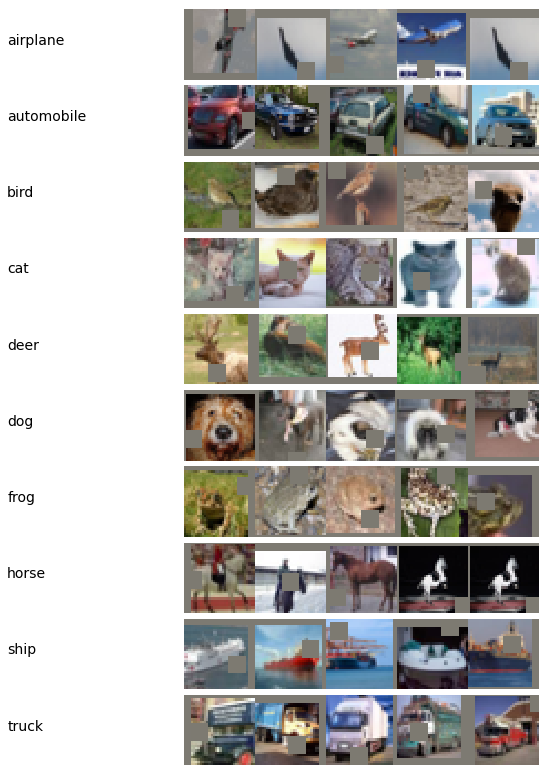

In [8]:
from __future__ import print_function
def unnormalize(img):
  img = img.cpu().numpy().astype(dtype=np.float32)
  
  for i in range(img.shape[0]):
    img[i] = (img[i]*channel_stdevs[i])+channel_means[i]
  
  return np.transpose(img, (1,2,0))

%matplotlib inline
import matplotlib.pyplot as plt
dataiter = iter(train_loader)

images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

num_classes = 10
# display 10 images from each category. 
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
r, c = 10, 11
n = 5
fig = plt.figure(figsize=(14,14))
fig.subplots_adjust(hspace=0.01, wspace=0.01)
for i in range(num_classes):
    idx = np.random.choice(np.where(labels[:]==i)[0], n)
    ax = plt.subplot(r, c, i*c+1)
    ax.text(-1.5, 0.5, class_names[i], fontsize=14)
    plt.axis('off')
    for j in range(1, n+1):
      plt.subplot(r, c, i*c+j+1)
      plt.imshow(unnormalize(images[idx[j-1]]), interpolation='none')
      plt.axis('off')
plt.show()

# Model Creation

We will be calling S11Net model here.

In [33]:
from eva4models.s11net import S11Net
import torch
model = S11Net()
use_cuda = torch.cuda.is_available()
model.device = torch.device("cuda" if use_cuda else "cpu")
model.to(model.device)
model.summary((3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
         ResBlock-14          [-1, 128,

In [10]:
model

S11Net(
  (prepLayer): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer1): S11Block(
    (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (res): ResBlock(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU()
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu2): ReLU()
    )
  )
  (l

# LR Finder
train for 10 epochs by exponentially moving LR from 1e-5 to 2


Learning rate search finished. See the graph with {finder_name}.plot()


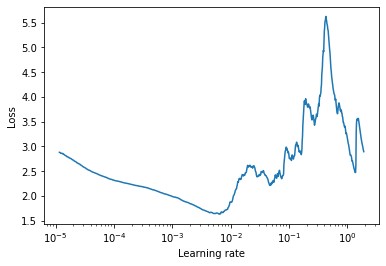

In [20]:
# LR finder
import torch.nn as nn
import torch.nn.functional as F
from eva4LRFinder import LRFinder
import torch.optim as optim
L1lambda = 0
L2lambda = 1e-4
criterion = F.nll_loss
optimizer = optim.SGD(model.parameters(), lr=1e-5)
lr_finder = LRFinder(model, optimizer, criterion, device=model.device)
lr_finder.range_test(train_loader, end_lr=5, num_iter=len(train_loader)*10, step_mode='linear')
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

In [21]:
loss = lr_finder.history['loss']
lr = lr_finder.history['lr']
print(lr[loss.index(min(loss))])


0.006338303015853813


Using plotly so as to see the values clearly

In [0]:
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go

def enable_plotly_in_cell():
  import IPython
  from plotly.offline import init_notebook_mode
  display(IPython.core.display.HTML('''<script src="/static/components/requirejs/require.js"></script>'''))
  init_notebook_mode(connected=False)
  

In [0]:
def plotly_plot(x, y, title = '', xscale='linear', yscale='linear'):
    enable_plotly_in_cell()
    data = []
    trace = go.Scatter(
            x = x,
            y = y,
            mode = 'lines',
            name = title
      )
    data.append(trace)
    
    layout = dict(title = title, yaxis_type=yscale, xaxis_type=xscale)
    fig = dict(data = data, layout = layout)
    iplot(fig, show_link=False)

In [30]:
plotly_plot(lr, loss, "LR Range")

In [25]:
max_lr = lr[loss.index(min(loss))]
max_lr

0.006338303015853813

This test indicates the mx lr to use as 0.0073 and start of reducing is 100 times less than that. 

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions using One Cycle Policy Scheduler. We use final_div_factor = 1 so as there is no annihilation.

In [34]:
import torch.optim as optim
import torch.nn as nn
batch_size=512
#from torch.optim.lr_scheduler import StepLR
#optimizer = torch.optim.SGD(model.parameters(), lr=0.08, momentum=0.95, weight_decay=1e-4)
L1lambda = 0
L2lambda = 0
EPOCHS = 24
max_lr = 0.1
optimizer = optim.SGD(model.parameters(), lr=max_lr/100, weight_decay=L2lambda)
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=max_lr, steps_per_epoch=len(train_loader), div_factor=5, pct_start=0.2, epochs=EPOCHS)
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=max_lr, steps_per_epoch=int(len(train)/batch_size)+1, epochs=EPOCHS,  pct_start=5/24, div_factor=100, final_div_factor=1 )
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=max_lr, steps_per_epoch=int(len(train_loader))+1, epochs=EPOCHS,  pct_start=0.2, div_factor=100, final_div_factor=1 )
print("Initial LR- ",scheduler.get_lr())
print("Total steps - ", scheduler.total_steps)
print("No.of steps to increase LR -", scheduler.step_size_up)
print("No.of steps to reduce LR - ", scheduler.step_size_down)

model.gotrain(optimizer, train_loader, test_loader, EPOCHS, "/content/drive/My Drive", scheduler, True,L1lambda)

Initial LR-  [0.0010000000000000009]
Total steps -  2376
No.of steps to increase LR - 474.20000000000005
No.of steps to reduce LR -  1900.8



Validation loss decreased (100000.000000 --> 1.701330).  Saving model ...
Epoch: 1, Train set: Average loss: 0.0036, Accuracy: 37.34%; Test set: Average loss: 1.7013, Accuracy: 46.41%
Learning Rate = 0.011072



Epoch: 2, Train set: Average loss: 0.0033, Accuracy: 49.95%; Test set: Average loss: 2.0627, Accuracy: 58.09%
Learning Rate = 0.037188



Epoch: 3, Train set: Average loss: 0.0026, Accuracy: 61.90%; Test set: Average loss: 1.8154, Accuracy: 53.27%
Learning Rate = 0.068721



Validation loss decreased (1.701330 --> 1.092965).  Saving model ...
Epoch: 4, Train set: Average loss: 0.0025, Accuracy: 64.22%; Test set: Average loss: 1.0930, Accuracy: 68.17%
Learning Rate = 0.092840



Validation loss decreased (1.092965 --> 0.803633).  Saving model ...
Epoch: 5, Train set: Average loss: 0.0017, Accuracy: 74.00%; Test set: Average loss: 0.8036, Accuracy: 75.84%
Learning Rate = 0.099983



Validation loss decreased (0.803633 --> 0.547897).  Saving model ...
Epoch: 6, Train set: Average loss: 0.0013, Accuracy: 78.99%; Test set: Average loss: 0.5479, Accuracy: 81.54%
Learning Rate = 0.099127



Epoch: 7, Train set: Average loss: 0.0011, Accuracy: 81.66%; Test set: Average loss: 0.6009, Accuracy: 80.71%
Learning Rate = 0.096998



Epoch: 8, Train set: Average loss: 0.0009, Accuracy: 83.87%; Test set: Average loss: 0.5897, Accuracy: 82.60%
Learning Rate = 0.093652



Validation loss decreased (0.547897 --> 0.476115).  Saving model ...
Epoch: 9, Train set: Average loss: 0.0009, Accuracy: 85.21%; Test set: Average loss: 0.4761, Accuracy: 83.46%
Learning Rate = 0.089176



Validation loss decreased (0.476115 --> 0.450885).  Saving model ...
Epoch: 10, Train set: Average loss: 0.0008, Accuracy: 86.65%; Test set: Average loss: 0.4509, Accuracy: 85.52%
Learning Rate = 0.083688



Validation loss decreased (0.450885 --> 0.441207).  Saving model ...
Epoch: 11, Train set: Average loss: 0.0007, Accuracy: 87.38%; Test set: Average loss: 0.4412, Accuracy: 85.27%
Learning Rate = 0.077331



Validation loss decreased (0.441207 --> 0.416556).  Saving model ...
Epoch: 12, Train set: Average loss: 0.0006, Accuracy: 88.91%; Test set: Average loss: 0.4166, Accuracy: 87.17%
Learning Rate = 0.070271



Validation loss decreased (0.416556 --> 0.397495).  Saving model ...
Epoch: 13, Train set: Average loss: 0.0006, Accuracy: 89.87%; Test set: Average loss: 0.3975, Accuracy: 87.73%
Learning Rate = 0.062694



Validation loss decreased (0.397495 --> 0.395578).  Saving model ...
Epoch: 14, Train set: Average loss: 0.0005, Accuracy: 90.81%; Test set: Average loss: 0.3956, Accuracy: 87.19%
Learning Rate = 0.054798



Epoch: 15, Train set: Average loss: 0.0005, Accuracy: 91.12%; Test set: Average loss: 0.4199, Accuracy: 87.17%
Learning Rate = 0.046789



Validation loss decreased (0.395578 --> 0.369552).  Saving model ...
Epoch: 16, Train set: Average loss: 0.0004, Accuracy: 92.43%; Test set: Average loss: 0.3696, Accuracy: 88.91%
Learning Rate = 0.038878



Validation loss decreased (0.369552 --> 0.346020).  Saving model ...
Epoch: 17, Train set: Average loss: 0.0004, Accuracy: 93.09%; Test set: Average loss: 0.3460, Accuracy: 89.14%
Learning Rate = 0.031270



Validation loss decreased (0.346020 --> 0.321440).  Saving model ...
Epoch: 18, Train set: Average loss: 0.0003, Accuracy: 94.03%; Test set: Average loss: 0.3214, Accuracy: 89.99%
Learning Rate = 0.024166



Epoch: 19, Train set: Average loss: 0.0003, Accuracy: 94.82%; Test set: Average loss: 0.3220, Accuracy: 90.46%
Learning Rate = 0.017752



Validation loss decreased (0.321440 --> 0.304537).  Saving model ...
Epoch: 20, Train set: Average loss: 0.0003, Accuracy: 95.50%; Test set: Average loss: 0.3045, Accuracy: 90.64%
Learning Rate = 0.012194



Validation loss decreased (0.304537 --> 0.302688).  Saving model ...
Epoch: 21, Train set: Average loss: 0.0002, Accuracy: 96.13%; Test set: Average loss: 0.3027, Accuracy: 90.89%
Learning Rate = 0.007640



Validation loss decreased (0.302688 --> 0.299292).  Saving model ...
Epoch: 22, Train set: Average loss: 0.0002, Accuracy: 96.56%; Test set: Average loss: 0.2993, Accuracy: 91.17%
Learning Rate = 0.004207



Epoch: 23, Train set: Average loss: 0.0002, Accuracy: 96.90%; Test set: Average loss: 0.2997, Accuracy: 91.52%
Learning Rate = 0.001987



Validation loss decreased (0.299292 --> 0.290928).  Saving model ...
Epoch: 24, Train set: Average loss: 0.0002, Accuracy: 97.22%; Test set: Average loss: 0.2909, Accuracy: 91.59%
Learning Rate = 0.001036



In [35]:
for idx, group in enumerate(scheduler.optimizer.param_groups):
  print(group['initial_lr'], group['max_lr'], group['min_lr'])
  

0.001 0.1 0.001


In [36]:
print(max(model.stats().train_acc))
print(max(model.stats().test_acc))

0.97216
0.9159


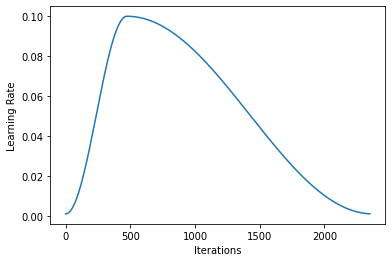

In [37]:
plt.xlabel("Iterations")
plt.ylabel("Learning Rate")
plt.plot(model.stats().batch_lr)
plt.show()

# Accuracy curves

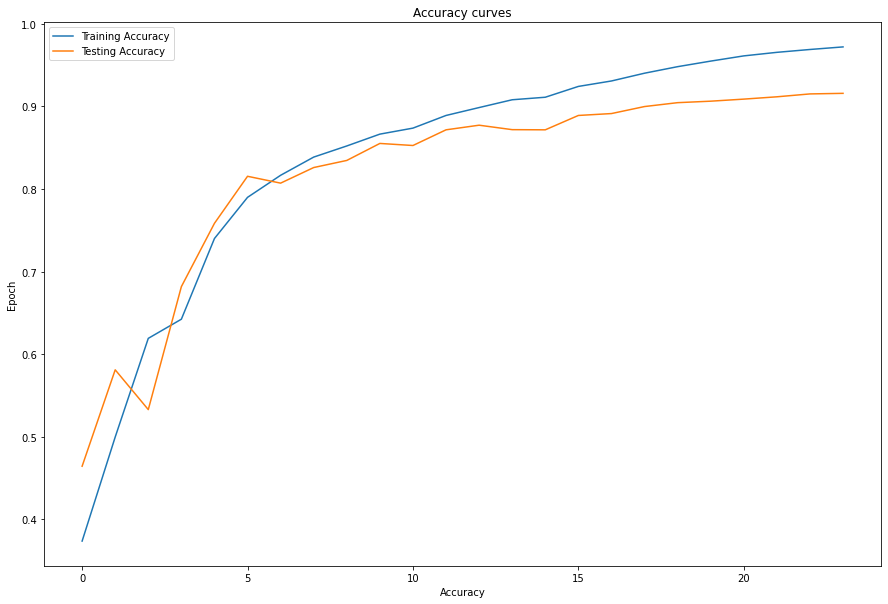

In [38]:
plt.figure(figsize=(15, 10))
ax = plt.subplot(111)
ax.plot(model.stats().train_acc)
ax.plot(model.stats().test_acc)

ax.set(title="Accuracy curves", xlabel="Accuracy", ylabel="Epoch")
ax.legend(['Training Accuracy', 'Testing Accuracy'], loc='best')
plt.savefig("TrainTestAccuracy.png")
plt.show()

# Misclassified images

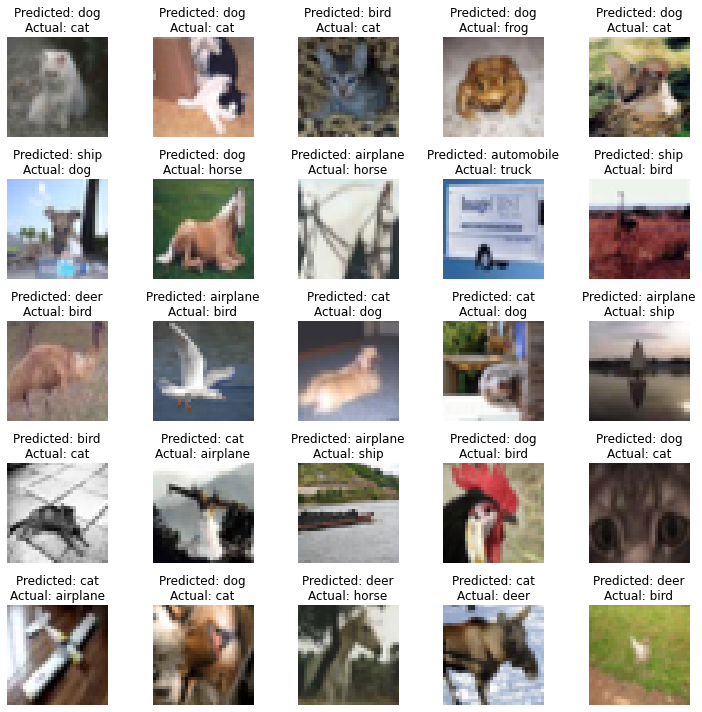

In [39]:

import plots

plots.plot_images(model.stats().get_misclassified_images(), class_names, "misclassified_imgs.png", mean=list(channel_means), std=list(channel_stdevs))


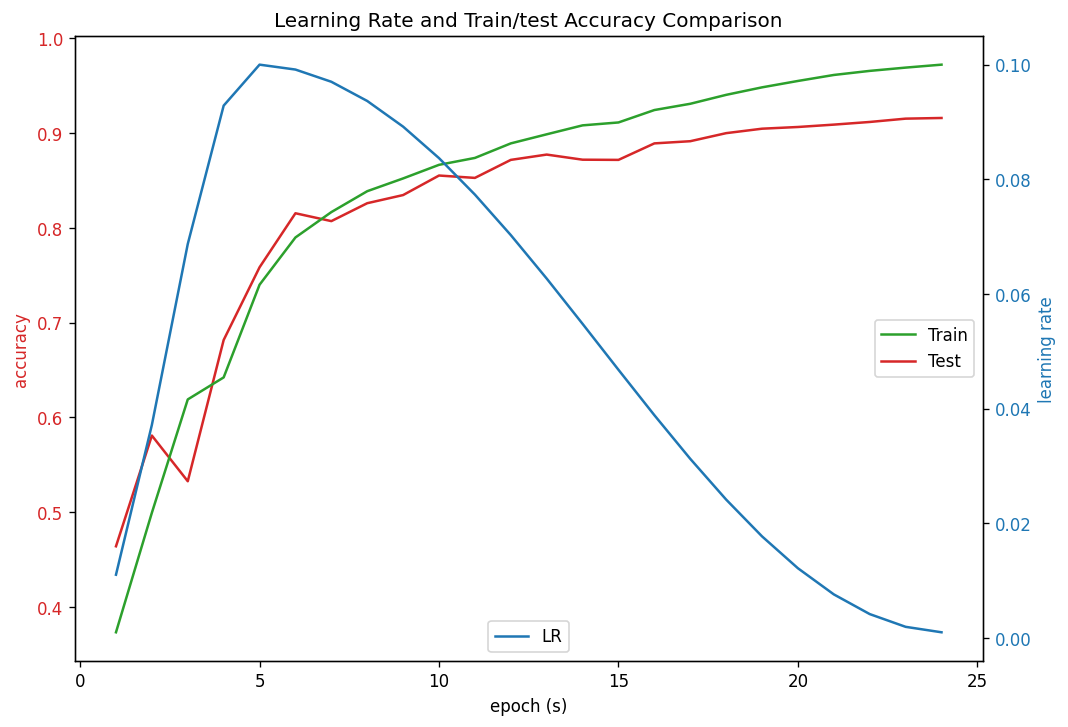

In [40]:
plt.rcParams.update({'figure.figsize':(9,6), 'figure.dpi':120})
fig, ax1 = plt.subplots()
t = np.arange(1, 25)
color = 'tab:red'
ax1.set_xlabel('epoch (s)')
ax1.set_ylabel('accuracy', color=color)
testline, = ax1.plot(t, model.stats().test_acc, color=color)
ax1.tick_params(axis='y', labelcolor=color)

color = 'tab:green'
trainline, = ax1.plot(t, model.stats().train_acc, color=color)
ax1.legend((trainline, testline), ('Train', 'Test'), loc=7)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('learning rate', color=color)  # we already handled the x-label with ax1
lrline, = ax2.plot(t, model.stats().lr, color=color)
ax2.legend((lrline, ), ('LR',), loc=8)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title("Learning Rate and Train/test Accuracy Comparison")
plt.show()

# GradCAM for misclassified images

In [0]:
mimages = model.stats().get_misclassified_images()
images = []
target_classes = []
pred_classes = []
for i in mimages:
  images.append(i["img"].cpu())
  target_classes.append(int(i['target']))
  pred_classes.append(int(i['pred']))

In [42]:
print(target_classes)
print(pred_classes)

[3, 3, 3, 6, 3, 5, 7, 7, 9, 2, 2, 2, 5, 5, 8, 3, 0, 8, 2, 3, 0, 3, 7, 4, 2]
[5, 5, 2, 5, 5, 8, 5, 0, 1, 8, 4, 0, 3, 3, 0, 2, 3, 0, 5, 5, 3, 5, 4, 3, 4]


torch.Size([10, 10])
Generating Grad-CAM @layer1
Generating Grad-CAM @layer2
Generating Grad-CAM @layer3


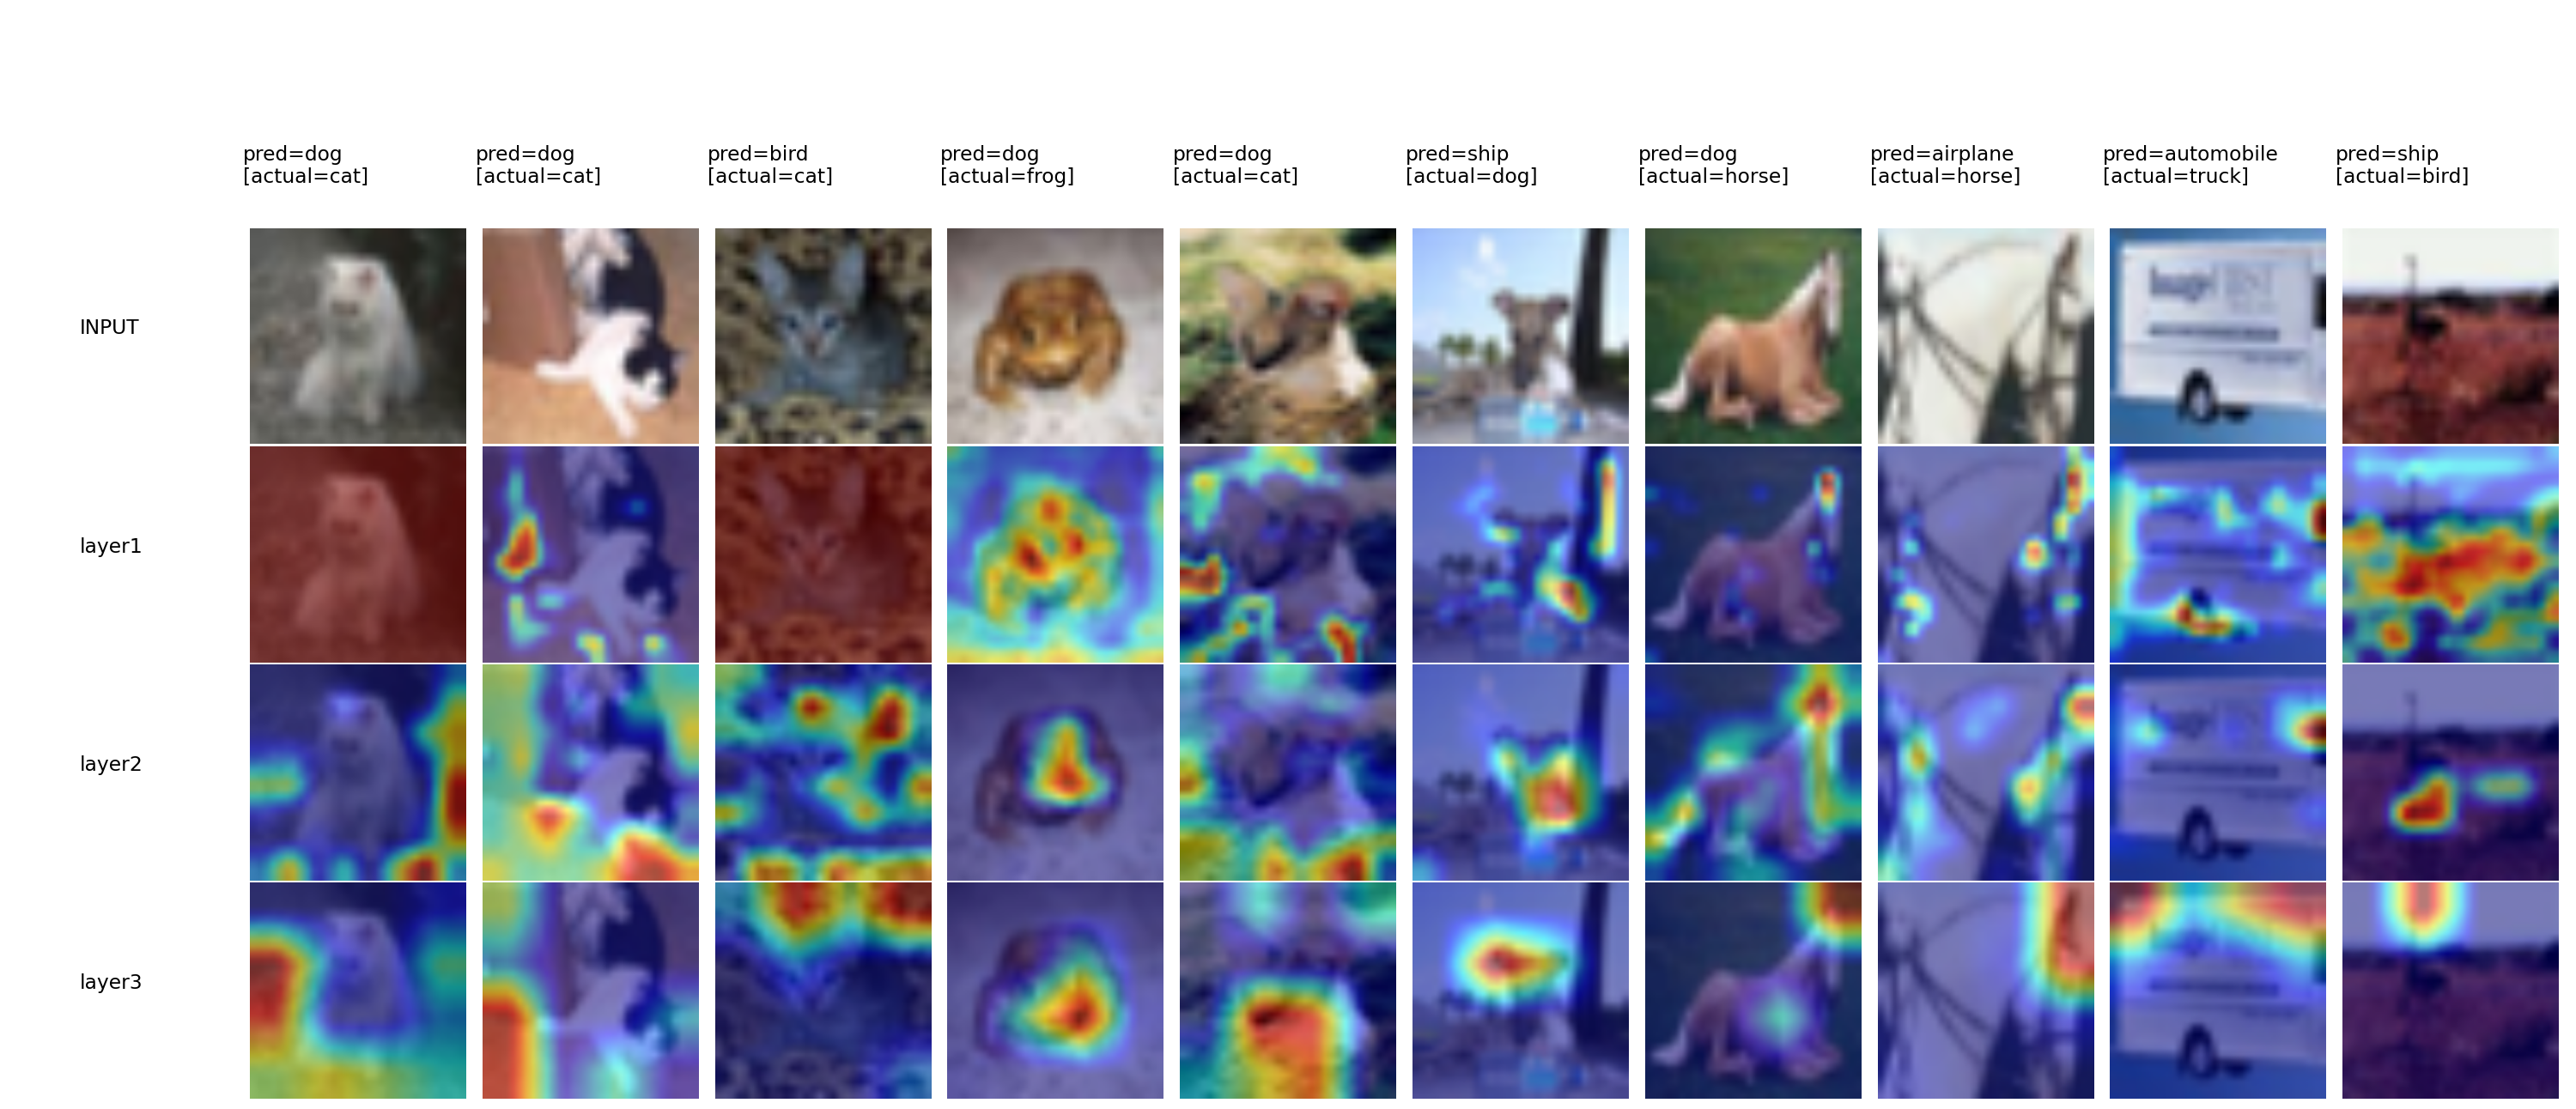

In [0]:
from eva4gradcam import GRADCAM, PLOT
target_layers = ["layer1", "layer2", "layer3"]
#Gradcam plot for first 10 misclassified images
gradcam_output, probs, predicted_classes = GRADCAM(images[:10], target_classes[:10], model, target_layers)
PLOT(gradcam_output, images[:10], target_classes[:10], target_layers, class_names, (3, 32, 32), predicted_classes, unnormalize)
#Gradcam plot for 11-20 misclassified images
gradcam_output, probs, predicted_classes = GRADCAM(images[10:20], target_classes[10:20], model, target_layers)
PLOT(gradcam_output, images[10:20], target_classes[10:20], target_layers, class_names, (3, 32, 32), predicted_classes, unnormalize)
#Gradcam plot for 21-25 misclassified images
gradcam_output, probs, predicted_classes = GRADCAM(images[20:], target_classes[20:], model, target_layers)
PLOT(gradcam_output, images[20:], target_classes[20:], target_layers, class_names, (3, 32, 32), predicted_classes, unnormalize)